This notebook has been made to determine a rough estimate of the receiver temperature and its error bars. This has been done by using the process described in Adam Beardsley's [memo](http://reionization.org/wp-content/uploads/2017/04/HERA19_Tsys_3April2017.pdf), which fit auto-correlation data to a simulated global sky model using the relationship.

In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
import matplotlib.pyplot as plt
import aipy
from astropy.io import fits
from scipy.stats import linregress
import os
import glob

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [2]:
def curve_to_fit(lsts, gain, offset):
    '''
    Define curve to fit data to
    offset is Tsys offset from zero = Trxr + g * <Tsky>
    '''
    global interp_values
    return (gain * interp_values + offset)

In [41]:
JD = 2458106

# Tsky_file = '/data4/tcox/HERA_IDR1_analysis/HERA_Tsky.npz'
Tsky_file = '/Users/tyler/Folders/Research/HERA/Tsys/data/HERA_tsky_fast.npz'
data = np.load(Tsky_file)
freqs = data['freqs']  # These are already made to fit the data
model_lsts = data['lsts']
model_HERA_Tsky = data['HERA_Tsky']

data = np.load('/Users/tyler/Folders/Research/HERA/Tsys/Tsys_plots/IDR2/2458098/fits.npz'.format(JD))
nrao_feeds = data['nrao_feeds']
HERA_list = data['HERA_list']
freqs = data['freqs']

# Load in data from previous script
autos_file = '/Users/tyler/Folders/Research/HERA/Tsys/data/IDR2_{}_autos.npz'.format(JD)
data = np.load(autos_file)
data_lsts = data['lsts']
data_ave = data['data_ave']

In [42]:
pols = ['X', 'Y']
npol = len(pols)
nant = len(HERA_list)

new_feeds = list(set(HERA_list)-set(nrao_feeds))

# Fit auto data to model
auto_fits = np.zeros((npol, nant, len(freqs), 2))  # gain_amp, gain_slope, rxr_amp
covs = np.zeros((npol, nant, len(freqs), 2, 2))

# Create interp_func to return Tsky - <Tsky> (ie, deviation from mean)
interp_Tsky = interpolate.interp1d(model_lsts, model_HERA_Tsky, kind='cubic', axis=2, fill_value='extrapolate')
interp_Tsky_array = interp_Tsky(data_lsts[0])
Tsky_mean = np.mean(interp_Tsky_array, axis=2)
Tsky_prime = interp_Tsky_array - np.expand_dims(Tsky_mean, 2)

In [43]:
def gain_rxr_temp(auto_fits, covs, save_npz=True):
    '''
    auto_fits[:, :, :, 0] -> A_0
    auto_fits[:, :, :, 1] -> R_0
    '''
    gains = auto_fits[:, :, :, 0]
    rxr_temp = auto_fits[:, :, :, 1] / gains - Tsky_mean[:, None, :]  
    rxr_temp_err = np.sqrt(covs[:,:,:,0,0] * auto_fits[:, :, :, 1]**2 / auto_fits[:, :, :, 0]**4  + 
                           covs[:,:,:,1,1] * 1.0 / auto_fits[:, :, :, 0]**2 - 
                           2 * covs[:,:,:,0,1] * auto_fits[:, :, :, 1] / auto_fits[:, :, :, 0]**3)
    if save_npz:
        np.savez('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{}/rxr_temp_w_err.npz'.format(JD), gains=gains, 
                                                                rxr_temp_err=rxr_temp_err, 
                                                                rxr_temp=rxr_temp,
                                                                auto_fits=auto_fits,
                                                                covs=covs)
    return gains, rxr_temp, rxr_temp_err

In [44]:
sim = True

if os.path.exists('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{}/rxr_temp_w_err.npz'.format(JD)) and not sim:
    fits_data = np.load('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{}/rxr_temp_w_err.npz'.format(JD))
    gains = fits_data['gains']
    rxr_temp_err = fits_data['rxr_temp_err']
    rxr_temp = fits_data['rxr_temp']
    covs = fits_data['covs']
    auto_fits = fits_data['auto_fits']

    
else:
    for pol in xrange(npol):
        for fi, freq in enumerate(freqs):
            interp_values = Tsky_prime[pol, fi, :]
            for anti, ant in enumerate(HERA_list):
                out = curve_fit(curve_to_fit, data_lsts[pol], data_ave[pol][ant, :, fi],
                                bounds=(0, np.inf))
                auto_fits[pol, anti, fi, :] = out[0]
                covs[pol, anti, fi, :, :] = out[1]
    gains, rxr_temp, rxr_temp_err = gain_rxr_temp(auto_fits, covs, save_npz=False)

## Reduced Chi-Squared

In [45]:
chi_sq = np.zeros((npol, len(freqs), len(HERA_list)))

for pol in xrange(npol):
    for fi, freq in enumerate(freqs):
        for anti, ant in enumerate(HERA_list):
            g,n = auto_fits[pol, anti, fi, :]
            chi_sq[pol, fi, anti] = np.sum((data_ave[pol][ant, :, fi] - (g * Tsky_prime[pol, fi, :] + n))**2) / (data_ave[pol][ant, :, fi].shape[0] - 2)

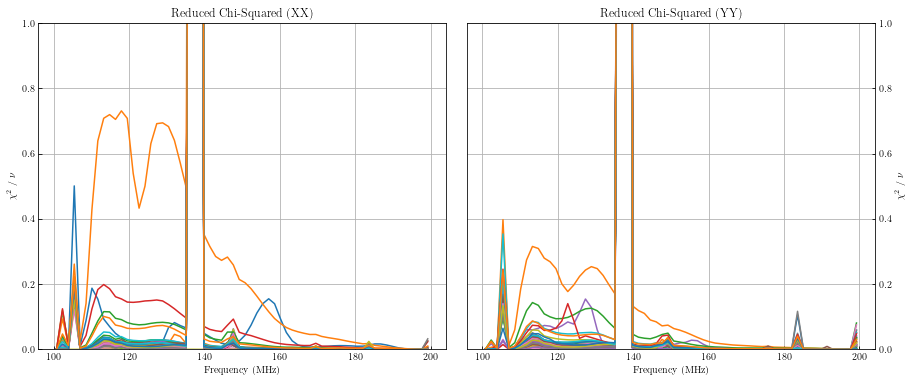

In [47]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for anti, ant in enumerate(HERA_list):
        axarr[poli].plot(freqs, chi_sq[poli, :, anti])
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_ylim([0, 1])
    axarr[poli].grid()
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[poli].set_ylabel(r'$\chi^2$ / $\nu$')
    axarr[poli].set_title('Reduced Chi-Squared ({})'.format(2*pol))
plt.subplots_adjust(wspace=0.05)